# BUSINESS UNDERSTANDING
Describe problem

In [34]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.neighbors import NearestNeighbors
import time
import pickle
import up_next.scrape
import up_next.viz
import up_next.discover
import up_next.viz
plt.style.use('ggplot')

In [35]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# DATA COLLECTION

        Collect artists in playlists
        Trim to frequent to artists
        Use trimmed artists to collect concerts
        
        uses up_next.scrape

# DATA UNDERSTANDING - Playlists

In [36]:
playlists = pd.read_json('up_next/data/raw/playlists_artists_redundant.json', lines=True)
concerts = pd.read_json('up_next/data/raw/artists_shows.json', lines=True)

In [37]:
playlists.head()

,artist,playlist
0,DJ Snake,"[Today's Top Hits, 37i9dQZF1DXcBWIGoYBM5M]"
1,TINI,"[Today's Top Hits, 37i9dQZF1DXcBWIGoYBM5M]"
2,Bon Iver,"[Today's Top Hits, 37i9dQZF1DXcBWIGoYBM5M]"
3,Jon Z,"[Today's Top Hits, 37i9dQZF1DXcBWIGoYBM5M]"
4,Martin Garrix,"[Today's Top Hits, 37i9dQZF1DXcBWIGoYBM5M]"


Artists and the playlists they appear in.
Playlist value is currently nested. In order to one hot encode this should be trimmed to just the second element, the unique playlist id.

### Artist Occurances

In [38]:
playlists.artist.value_counts()[:25]

J Balvin          248
Bad Bunny         214
Drake             202
Cardi B           186
Daddy Yankee      182
Farruko           180
Nicky Jam         178
Ozuna             176
Maluma            174
Khalid            172
Ed Sheeran        170
Nicki Minaj       165
Camila Cabello    150
Justin Bieber     146
Marshmello        146
Diplo             144
Beyoncé           143
Ty Dolla $ign     138
Anuel Aa          136
Zion & Lennox     132
Shawn Mendes      132
Rihanna           128
Wisin             128
Natti Natasha     124
Post Malone       122
Name: artist, dtype: int64

#### Visualize Playlist Appearances

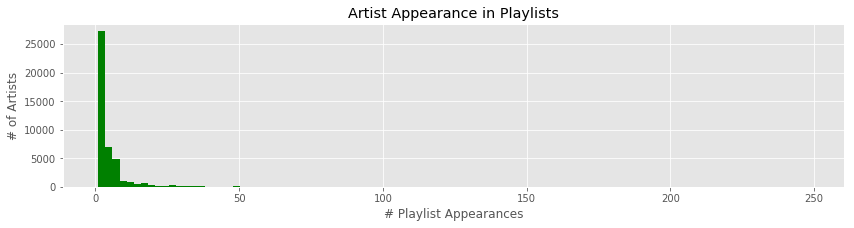

In [39]:
plt.figure(figsize=(14,3))
playlists.artist.value_counts().hist(bins=100, color='g')
plt.xlabel('# Playlist Appearances')
plt.ylabel('# of Artists')
plt.title('Artist Appearance in Playlists');

We won't be able to gain much information from artists only appearing in a few playlists.
Dropping them will reduce computational cost with little cost to predicting similar artists.

# DATA UNDERSTANDING - Concerts

In [40]:
concerts.head()

,artist,date,loc
0,2 Chainz,2019-06-30 05:30:00,"Las Vegas, NV, US"
1,2 Chainz,2019-07-12 11:00:00,"London, UK"
2,2 Chainz,2019-08-10 00:00:00,"Anaheim, CA, US"
3,2 Chainz,2019-08-24 22:00:00,"Atlanta, GA, US"
4,2 Chainz,2019-05-27 05:30:00,"Las Vegas, NV, US"


In [41]:
concerts.describe()

,artist,date,loc
count,134943,134943,134943
unique,1420,37136,4820
top,San Francisco Symphony,2019-07-19 00:00:00,"London, UK"
freq,194,191,4186
first,NaN,1973-09-29 00:00:00,NaN
last,NaN,2020-12-16 18:30:00,NaN


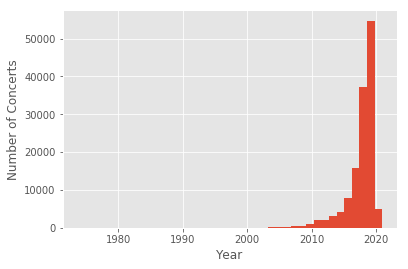

In [42]:
concerts.date.hist(bins=40)
plt.xlabel('Year')
plt.ylabel('Number of Concerts');

Artists and the time and place of their concerts. The earliest time dates back to 1973 and location includes non-US concerts. For this experiment we will just focus on concerts in the United States and from 2015 or later. ALSO that loc column should be renamed to prevent ambiguation with Pandas' .loc() method.

# DATA PREPARATION - Playlists
        Trim rare artists, ohe playlists

#### Trim rarer artists

In [43]:
cutoff = 20
top_artists_counts = [(v, c) for v, c in playlists['artist'].value_counts().items()
                      if c >= cutoff]
n_remaning_artists = len(top_artists_counts)
print(f'There are {n_remaning_artists} artists appearing in {cutoff} or more playlists')
print('The twelve most prevalent are ...')
top_artists_counts[:12]

There are 1697 artists appearing in 20 or more playlists
The twelve most prevalent are ...


[('J Balvin', 248),
 ('Bad Bunny', 214),
 ('Drake', 202),
 ('Cardi B', 186),
 ('Daddy Yankee', 182),
 ('Farruko', 180),
 ('Nicky Jam', 178),
 ('Ozuna', 176),
 ('Maluma', 174),
 ('Khalid', 172),
 ('Ed Sheeran', 170),
 ('Nicki Minaj', 165)]

In [44]:
top_artists=[x[0] for x in top_artists_counts]
trimmed_playlists = playlists[playlists['artist'].isin(top_artists)].copy()
trimmed_playlists.shape

(65242, 2)

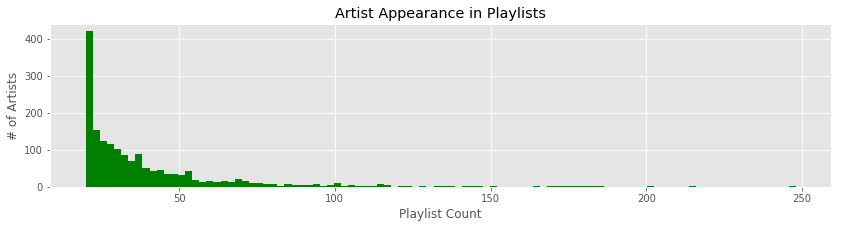

In [45]:
plt.figure(figsize=(14,3))
trimmed_playlists['artist'].value_counts().hist(bins=100, color='g')
plt.xlabel('Playlist Count')
plt.ylabel('# of Artists')
plt.title('Artist Appearance in Playlists');

     - Collect Concert data on artists in trimmed playlists - 

### One Hot Encoding Playlist Presence

Cut the lists in the playlist column to just the second element (unique id).

In [90]:
trimmed_playlists['playlist'] = trimmed_playlists['playlist'].apply(lambda x: x[1])   
                                                    # Resetting playlist column values to only second element

Create a dataframe of each artist and flags for their playlist presences

In [91]:
encoder = OneHotEncoder()
encoder.fit(trimmed_playlists[['playlist']])

ohe_playlists= pd.DataFrame(
                encoder.transform(trimmed_playlists[['playlist']]).toarray(),
                columns=encoder.get_feature_names(['playlist'])
                )                            # Making a column for each unique playlist

In [92]:
artists_ohe_singles = pd.concat([trimmed_playlists.drop('playlist', axis=1),
                                   ohe_playlists],
                                   axis=1)          # Stitching these flags onto the artists

In [93]:
artists_playlists = artists_ohe_singles.groupby('artist').sum()
                                                    # Stacking the individual flags per artist

In [94]:
len(trimmed_playlists.artist.unique()), len(artists_playlists)  # Sanity Check that we didn't lose or gain rows.

(1697, 1697)

In [95]:
cleaned_playlists = artists_playlists.reset_index()
cleaned_playlists.head()

,artist,playlist_03lUYFsfkESxG71B2dYosj,playlist_08CJ6fWrTA1vMfwVwAxWUl,playlist_0Gy1TwCxPFTMCiwxGLVkc1,playlist_0T22esVKW7cTZEN7XzXV14,playlist_0YMVY3uhQNd7WUf0hSByrX,playlist_0ZWYUjUMhaq0Rammqq3qu1,playlist_0bx5Dgu5yOEhST49LP67su,playlist_0fmLn46c92nP4dePQSZlsz,playlist_0k7YwkrfJ2BsRMFBP5W5xK,...,playlist_73gXbLcjix7p1pPsQClusE,playlist_7A2YimOfIrmAWkCeSIY8Rq,playlist_7EnyqmmhFgfhicejZiVV13,playlist_7EpJpnU6KrSc430F8B5tM7,playlist_7FDyC1JdV3jkGzAE9BONKt,playlist_7HQu1GUDVSx64GdCpaB88I,playlist_7JXJKP3xMvIMbEBBGApTPQ,playlist_7b9DiMN2kttG8lYQogfQBw,playlist_7fzFQUIVM4TumzRWo5UFP2,playlist_7kdOsNnHtzwncTBnI3J17w
0,(G)I-DLE,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,*NSYNC,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,2 Chainz,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,21 Savage,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,2Pac,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [101]:
cleaned_playlists.to_json('up_next/data/cleaned/cleaned_playlists.json', orient='records', lines=True)

# DATA PREPARATION - Concerts
        Trim to recent, domestic + geocode unique locs and join

In [69]:
concerts.columns = ['artist', 'date', 'location']          # Rename column loc -> location
domestics = concerts[concerts['location'].str.endswith('US')]      # Drop gigs outside USA
recent_domestics = domestics[domestics['date'] >= '2015']      # Drop gigs older than 2015
trimmed_concerts = recent_domestics.copy()

unique_locations = trimmed_concerts.location.unique()
f'There are {len(unique_locations)} unique locations'

'There are 2023 unique locations'

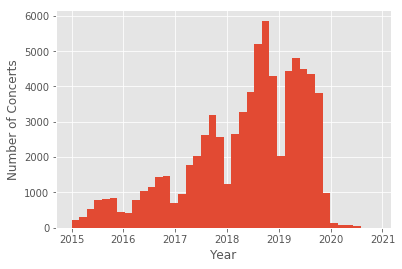

In [72]:
trimmed_concerts.date.hist(bins=40)
plt.xlabel('Year')
plt.ylabel('Number of Concerts');

Collect geo coordinates from Google Maps

In [95]:
# start = time.time()
# locations_w_coords = up_next.gmap.get_multi_latlongs(unique_locations)
# time.time() - start    

# Takes a little while to run. ~7:30 min

In [98]:
locations_w_coords.head()

,lat,lng,location
0,36.169941,-115.139830,"Las Vegas, NV, US"
1,33.836593,-117.914301,"Anaheim, CA, US"
2,33.748995,-84.387982,"Atlanta, GA, US"
3,42.331427,-83.045754,"Detroit, MI, US"
4,40.691613,-112.001050,"West Valley City, UT, US"


In [102]:
concerts_w_coords = pd.merge(trimmed_concerts, locations_w_coords, on='location', how='left')
display(concerts_w_coords.head())
len(trimmed_concerts) == len(concerts_w_coords)     # Sanity Check for merge quality

,artist,date,location,lat,lng
0,2 Chainz,2019-06-30 05:30:00,"Las Vegas, NV, US",36.169941,-115.139830
1,2 Chainz,2019-08-10 00:00:00,"Anaheim, CA, US",33.836593,-117.914301
2,2 Chainz,2019-08-24 22:00:00,"Atlanta, GA, US",33.748995,-84.387982
3,2 Chainz,2019-05-27 05:30:00,"Las Vegas, NV, US",36.169941,-115.139830
4,2 Chainz,2019-05-19 00:00:00,"Detroit, MI, US",42.331427,-83.045754


True

In [51]:
concerts_w_coords['artist'].unique().shape

(1355,)

1355 Unique artists in our concerts data out of the 1697 from the trimmed playlist.
Re trim playlist df???

In [105]:
concerts_w_coords.to_json('up_next/data/cleaned/concerts_w_coords.json', orient='records', lines=True)

# MODELING

In [3]:
cleaned_playlists = pd.read_json('up_next/data/cleaned/cleaned_playlists.json', lines=True)
concerts_w_coords = pd.read_json('up_next/data/cleaned/concerts_w_coords.json', lines=True)

In [5]:
# concerts_w_coords[concerts_w_coords['artist'].str.contains('Head and')]

### Similar Artist

In [60]:
model = up_next.discover.SimilarArtistModel(playlists_df=cleaned_playlists, concerts_df=concerts_w_coords)

In [59]:
untapped = model.find_similar_artist_venues(cutoff_dist=100,
                                 main_artist='Luke Bryan',
                                 max_new_cities=5,
                                 num_artists=10)

In [56]:
up_next.viz.add_multi_artist_markers('Luke Bryan', untapped)

### EVALUATION

In [31]:
main_artist = 'Arcade Fire'
untapped = model.find_similar_artist_venues(main_artist, cutoff_dist=5, max_new_cities=10)
up_next.viz.add_multi_artist_markers(main_artist, untapped)

'Arcade Fire: No Recent Shows OR Not In 20 Of Top Playlists'

In [43]:
main_artist in top_artists, main_artist in playlists.artist.unique()

(False, True)

Always need more data!

### DEPLOYMENT

In [61]:
# pickle the model
with open('up_next/webapp/sim_artist_model.pkl', 'wb') as f:
    pickle.dump(model, f)

In [52]:
# stand up w flask at url

Lets get a list of unique artist names to implement into the options.

In [8]:
artists_list = concerts_w_coords.drop_duplicates(subset='artist')['artist']
artists_list.to_csv('up_next/data/cleaned/artists_list.csv', header=True)